# Exploring the Top Incomes Database with Pandas and Matplotlib

**Author:** [Ramiro Gómez](http://ramiro.org/)

The [World Top Incomes Database](http://topincomes.g-mond.parisschoolofeconomics.eu/) originated from research by Thomas Piketty on the distribution of top incomes in France in 2001 and has since then gathered information for more than 20 countries generating a large volume of data, intended as a resource for further analysis and research. The database is compiled and maintained by Facundo Alvaredo, Tony Atkinson, Thomas Piketty and Emmanuel Saez.

The income data being explored in this notebook was downloaded on July 25, 2015. 

In [1]:
%load_ext signature
%matplotlib inline

import itertools
import math

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('ramiro')

df = pd.read_excel('csv/top-incomes.xlsx', 1, skiprows=1)

chartinfo = 'Author: Ramiro Gómez - ramiro.org • Data: World Top Incomes Database - parisschoolofeconomics.eu'
infosize = 13

## Exploring the dataset

In [2]:
df.head()

,Country,Year,Top 10% income share,Top 10% income share-LAD,Top 10% income share-married couples & single adults,Top 10% income share-adults,Top 10% income share-tax data,Top 10% income share-IDS,Top 5% income share,Top 5% income share-LAD,...,Top 0.5-0.1% average income-including capital gains,Top 0.1-0.01% average income-including capital gains,P90 income threshold-including capital gains,P95 income threshold-including capital gains,P99 income threshold-including capital gains,P99.5 income threshold-including capital gains,P99.9 income threshold-including capital gains,P99.99 income threshold-including capital gains,Pareto-Lorenz coefficient,Inverted Pareto-Lorenz coefficient
0,Argentina,1932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.659,2.517
1,Argentina,1933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.674,2.484
2,Argentina,1934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.652,2.534
3,Argentina,1935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.655,2.526
4,Argentina,1936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.723,2.382


The table has one record per year and country for more than 400 different variables. Coverage for each country and year varies in the top incomes database. To first compare countries in a single year, we have to make sure, that there is sufficient data available.

So let's find out the most recent year that has at least 15 records in the `Top 1% income share` column. We set column variables, create a new dataframe with the relevant columns, call the `value_counts()` method of the `Year` series, then select only the years with more then 15 records, and sort the result in descending order by year.

In [3]:
income_col = 'Top 1% income share'
cols = ['Year', 'Country', income_col]
df_top = df[cols].dropna(axis=0, how='any')

year_counts = df_top.Year.value_counts()
sufficient = year_counts[year_counts > 15]
sufficient.sort_index(ascending=False).head()

2010    16
2009    17
2008    17
2007    17
2006    17
dtype: int64

## Income share of the top 1% earners across countries in 2010

Since 2010 is the most recent year with enough records, it will be used for plotting a country ranking sorted by the income share of the top 1% earners from higher to lower percentages.

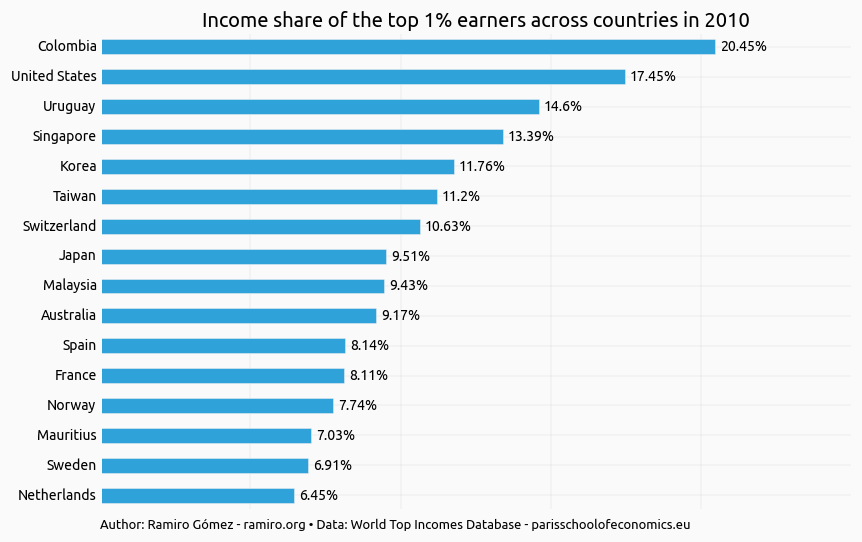

In [4]:
year = 2010
title = 'Income share of the top 1% earners across countries in {}'.format(year)

df_top_year = df_top[df_top['Year'] == year].sort(columns=[income_col])

s = df_top_year.set_index('Country')[income_col]
ax = s.plot(
    kind='barh',
    figsize=(12, 8), 
    title=title)
ax.tick_params(labelbottom='off')
ax.set_ylabel('', visible=False)

for i, label in enumerate(s):
    ax.annotate(str(label) + '%', (label + .2, i - .15))

plt.annotate(chartinfo, xy=(0, -1.04), xycoords='axes fraction', fontsize=infosize)
plt.savefig('img/income-share-top1-{}.png'.format(year), bbox_inches='tight')

## How the top 1% income share evolved in the past century

Next let's look at how the income share of the top 1% earners evolved during the past 100 years in all countries where at least one record is available within this period. To show change over time a line chart is often most suitable. Since there are more than 20 countries in the income database each country will be plotted as a separate line chart in a grid of small multiples.

First we create a pivot table, so that each country is in a separate column and the years are in rows. Then calculate the minimum and maximum years used in the title and to create the x-ticks, set the number of grid columns to 5 and deduce the appropriate number of rows, and set some descriptive text to be displayed at the bottom.

In [5]:
df_pivot = df_top.pivot(*cols)

num_countries = len(df_pivot.columns)
xmax = max(df_pivot.index)
xmin = xmax - 100

ncols = 5
nrows = math.ceil(num_countries / ncols)

title = 'Income share of the top 1% earners in {:d} countries between {:d} and {:d}'.format(num_countries, xmin, xmax)
footer = 'Included are countries with at least one record for the top 1% income share in the given time range.\n' + chartinfo

To create small multiples we use matplotlib's `subplots` method setting the number of rows and columns according to previous calculations and making sure the x- and y-axes have the same scale in each plot.

It's worth pointing out that the value range for the x-axes (`xlim`) is set for each chart explicitly since the pivot table also contains rows for years before 1914. These shall not be displayed though, because they do not contain data on the top 1% earners.

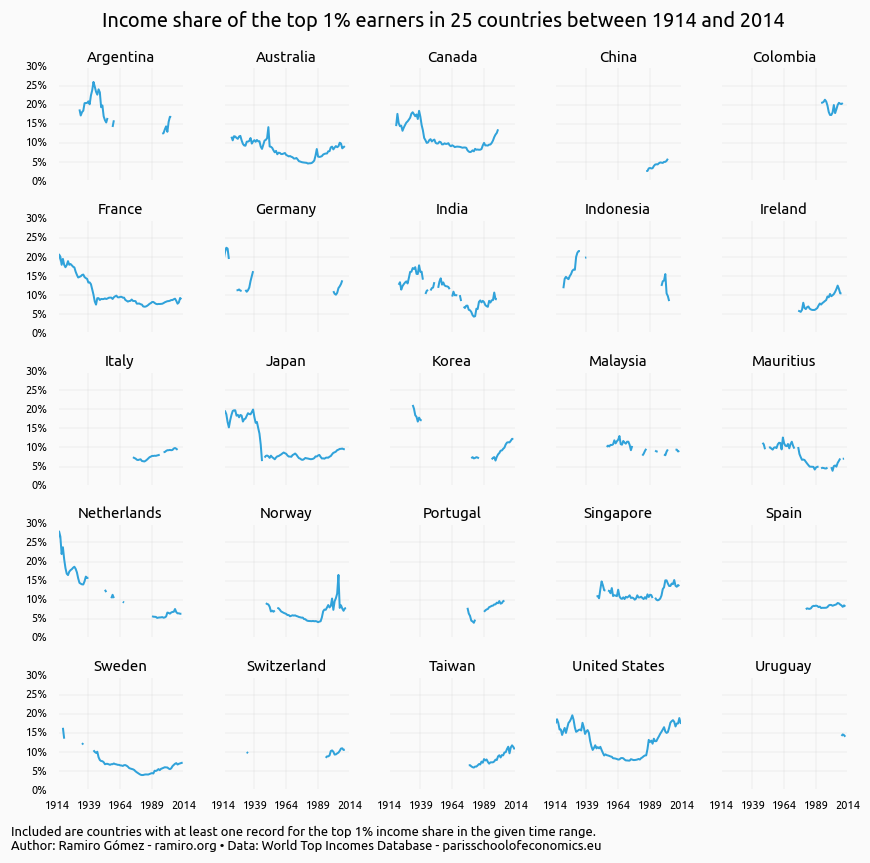

In [6]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True)
fig.suptitle(title, y=1.03, fontsize=20)
fig.set_figwidth(12)
fig.set_figheight(11)

for idx, coords in enumerate(itertools.product(range(nrows), range(ncols))):
    ax = axes[coords[0], coords[1]]
    country = df_pivot.columns[idx]
    df_pivot[country].plot(
        ax=ax,
        xlim=(xmin, xmax)
    )
    
    ax.set_title(country, fontsize=15)
    ax.set_xlabel('', visible=False)
    ax.set_xticks(list(range(xmin, xmax + 1, 25)))
    ax.tick_params(pad=10, labelsize=11)
    ax.tick_params(labelsize=11)
    ax.yaxis.set_major_formatter(
        mpl.ticker.FuncFormatter(lambda val, p: '{}%'.format(int(val))))


fig.text(0, -.03, footer, fontsize=infosize)
fig.tight_layout()

plt.savefig('img/income-share-top1-{}-countries-{}-{}.png'.format(num_countries, xmin, xmax), bbox_inches='tight')

We can see that in the displayed period France, Japan and the United States have the best data coverage for this indicator and countries like China, Colombia and Uruguay have very few data points.

The Netherlands went from an extremely high income share of almost 30% in 1914 to about 6 in 2014. Also in countries like France, Sweden and Japan the income share of the top earners is clearly lower than a hundred years ago. In the US and Canada there is a decreasing trend at the beginning and a steep increase in the more recent past.

## Evolution of top incomes in the US

The US having good data coverage and being a very strong economy let's now look at their evolution of the top incomes. We'll create a line chart that shows the average income and the average income including capital gains for the top 0.1% and 1%.

In [7]:
cols = [
    'Top 0.1% average income',
    'Top 0.1% average income-including capital gains', 
    'Top 1% average income',
    'Top 1% average income-including capital gains'
]
highlight = 'Top 0.1% average income-including capital gains'

df_us = df[df['Country'] == 'United States']
df_us.set_index('Year', inplace=True)

xmax = df_us.index.max()
xmin = xmax - 100

title = 'Evolution of the top incomes in the US from {} to {}'.format(xmin, xmax)

After setting the columns and limiting the dataset to the US, we can simply call the plot method of the `df_us` dataframe for drawing the lines. We could stop there, but we can improve the chart by making the numbers used as y-ticks easier to read, setting an appropriate label for the y-axes, set the legend position and size and add annotation with meta info and the 2 hightest values to add some historical context.

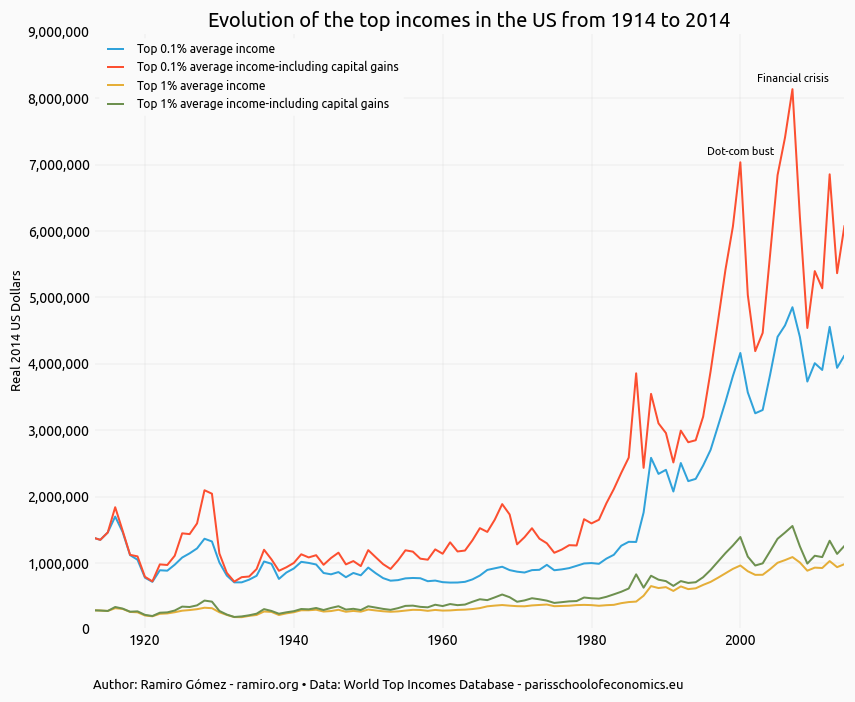

In [8]:
ax = df_us[cols].plot(figsize=(12, 10), title=title)

ax.yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda val, p: format(int(val), ',')))

ax.set_ylabel('Real 2014 US Dollars', fontsize=13)
ax.set_xlabel('', visible=False)
ax.legend(loc=2, prop={'size': 12})
plt.annotate(chartinfo, xy=(0, -1.1), xycoords='axes fraction', fontsize=infosize)

plt.annotate(
    'Dot-com bust', 
    xy=(2000, df_us.ix[2000][highlight]),
    xytext=(0, 5),
    textcoords='offset points',
    ha='center',
    va='bottom',
    size=11)

plt.annotate(
    'Financial crisis', 
    xy=(2007, df_us.ix[2007][highlight]),
    xytext=(0, 5),
    textcoords='offset points',
    ha='center',
    va='bottom',
    size=11)

plt.savefig('img/income-share-top-us-{}-{}.png'.format(xmin, xmax), bbox_inches='tight')

The average income of top 0.1% earners clearly increased the most over the hundred year period, most dramatically beginning in the mid 1980s. In the past 30 years we see the most extreme fluctuations, for example the steep increase and decline around the dot-com bust in 2000 and the financial crisis of 2007-08.

Especially, the richest of the rich earn a lot more than the vast majority of people. In the recent past there is a clear trend in the US and also other countries towards more income inequality, which is pretty alarming and bears a lot of potential for future conflicts.

In [9]:
%signature